# Assignment 1

## Hardware and software specifications of the computer
### Hardware


*   MacBook Air (Retina, 13-inch, 2018)
*   Processor: 1.6 GHz Intel Core i5
*   Memory: 8 GB 2133 MHz LPDDR3

### Software

*   Google Colab 
*   Anaconda Navigator Jupyter Notebook


## Step 1. Import libraries, load data and reshape data.

In [1]:
import h5py
import numpy as np
import time
from tqdm import tqdm
import matplotlib.pylab as pl
import matplotlib.pyplot as plt
import pandas as pd
import math

In [2]:
with h5py.File('./Input/train/images_training.h5','r') as H:
    data_train = np.copy(H['datatrain'])
with h5py.File('./Input/train/labels_training.h5','r') as H:
    label_train = np.copy(H['labeltrain'])

with h5py.File('./Input/test/images_testing.h5','r') as H:
    data_test = np.copy(H['datatest'])
with h5py.File('./Input/test/labels_testing_2000.h5','r') as H:
    label_test = np.copy(H['labeltest'])

# using H['datatest'], H['labeltest'] for test dataset.
print(data_train.shape,label_train.shape)
print(data_test.shape,label_test.shape)

(30000, 784) (30000,)
(5000, 784) (2000,)


In [3]:
data_test = data_test[0:2000, :]
print(data_train.shape, label_train.shape)
print(data_test.shape, label_test.shape)

(30000, 784) (30000,)
(2000, 784) (2000,)


## Step 2. Pre-process data and define functions.

### Validation

In [4]:
def split(test_ratio,X,label):
    #Randomly arrange the sequence and assign the randomly assigned index to the train set and the validation set
    shuffle_index = np.random.permutation(len(X))  
    test_size = int(len(X)*test_ratio) 
    test_index = shuffle_index[:test_size]   
    train_index = shuffle_index[test_size:] 
    X_train = X[train_index]  
    Y_train = label[train_index]  
    X_test = X[test_index]  
    Y_test = label[test_index]   
    return X_train,X_test,Y_train,Y_test

In [5]:
data_validation_train, data_validation_test, label_validation_train, label_validation_test = split(0.3,data_train,label_train) 

In [6]:
data_validation_test.shape

(9000, 784)

### SVD

In [7]:
def svd(x, n_components):
    U, s, Vt = np.linalg.svd(x, full_matrices=False)
    S = np.diag(s) # diagonal matrix
    x_svd = U[0:U.shape[0], 0:n_components].dot(S[0:n_components, 0:n_components]).dot(Vt[0:n_components, 0:Vt.shape[1]])
    return x_svd

### PCA

In [8]:
def pca(data,n):
    #Averaging
    row = data.shape[0]
    dimension = data.shape[1]
    avrs = np.array([np.mean(data[:,i]) for i in range(dimension)])
    temp = []
    temp = data - avrs #feature - avr
    #calculate scatter matrix and its eigenvalue & eigenvector
    scatter_matrix=np.dot(temp.T,temp)
    #feature value and vector of cov #784, 784*784
    feature_value,feature_vector = np.linalg.eig(scatter_matrix)
    #choose n components which is Principal Components
    pairs = [(np.abs(feature_value[i]), feature_vector[:,i]) for i in range(dimension)]
    pairs.sort(reverse=True)
    feature=np.array([ele[1] for ele in pairs[:n]])
    #Converted into reduced dimensionality data
    result = []
    result = np.dot(temp,np.transpose(feature))
    return feature,result

In [9]:
def pca_test(data,n):
    #Use the test set to subtract the mean of the test set
    #and then multiply the matrix obtained by the training set
    row = data.shape[0]
    dimension = data.shape[1]
    avrs = np.array([np.mean(data[:,i]) for i in range(dimension)])
    temp = []
    temp = data - avrs #feature - avr
    return  temp

### Normalization

In [10]:
def normalize(data):
    data_normalize = (data - np.min(data)) / (np.max(data) - np.min(data))
    return data_normalize

### KNN

In [11]:
def knn(X, label, K, X_q):
    result = []
    labelss = []
    row = X.shape[0]
    #calculate distance between train set and test set
    diff = np.tile(X_q,(row,1)) - X
    sqr = np.square(diff) 
    sqrsum = sqr.sum(axis=1)
    dis = np.sqrt(sqrsum)
    #sort distance
    arg_ascending = np.argsort(dis)
    #print(arg_ascending)
    for n in range(K):
        temp = label[arg_ascending[n]]
        labelss.append(temp)
    labels = max(labelss,key=labelss.count)
    #print(label)
    return labels
#X: data_train
#label: label_train
#X_q: data_test

### Naive Bayes

In [12]:
class NaiveBayes(object):
  def __init__(self):
    self.A = 1    
    self.K = 2

  def find_min(self,train):
    #find the minimum value of input set
    new_data = []
    for i in range(len(train)):
      new_data.append(np.min(train[i]))
    self.min = np.min(new_data)
    return self.min

  def predict(self,train,labels,test):
    labels = list(labels)
    row = train.shape[0]
    #temp = list(temp)    
    #prior prob of each class
    self.P_prior = []
    for i in np.unique(labels):
      self.P_prior.append(np.log((labels.count(i)+self.A) / (row+self.K*self.A))  ) #10 classes
    #add the absolute value in order to avoid negative value
    temp = {}
    extra = [abs(self.min)]*len(test)
    for c in np.unique(labels): #set(y)
      classes = []
      for sample,label in zip(train,labels):
        if label == c:
            classes.append(sample)
      temp[c] = classes + extra
    #conditional prob
    self.P = []
    counts = np.array([np.array(temp[i]).sum(axis=0) for i in temp.keys()]) + self.A #The number of times that features appears in each class 
    self.P = np.log(counts / counts.sum(axis=1)[np.newaxis].T)
    #post prob
    arg = np.argmax([(self.P * y).sum(axis=1) + self.P_prior for y in test], axis=1)
    return arg


## Step 3. Run the best model with best hyperparameters(tuning hyerparameter will be shown in Reference)

### KNN with best hyperparameters with data test

In [13]:
data_train_svd = svd(data_train, 200)
data_test_svd = svd(data_test, 200)

In [14]:
time_start = time.time()
 
KNN = 6
knn_svd_label_pred = np.zeros(len(data_test_svd))
for i in range(len(data_test_svd)):
    test_q = data_test_svd[i, :]
    svd_result = knn(data_train_svd, label_train, KNN, test_q)
    knn_svd_label_pred[i] = svd_result
svd_accuracy = np.sum(label_test == knn_svd_label_pred) / len(data_test_svd)
print(svd_accuracy)

time_end=time.time()
print('time cost',time_end-time_start,'s')

0.841
time cost 177.8353579044342 s


## Step 4. Get output

We choose KNN classifier with data after SVD.

In [15]:
with h5py.File('./Input/test/images_testing.h5','r') as H:
    data_test_output = np.copy(H['datatest'])

In [16]:
data_test_output_svd = svd(data_test_output, 200)

In [17]:
knn_svd_label_pred = np.zeros(len(data_test_output_svd))
for i in range(len(data_test_output_svd)):
    test_q = data_test_output_svd[i, :]
    svd_result = knn(data_train_svd, label_train, 6, test_q)
    knn_svd_label_pred[i] = svd_result

In [18]:
output = knn_svd_label_pred
with h5py.File('./Output/predicted_labels.h5','w') as H:
    H.create_dataset('Output',data=output)

## Reference: Tuning hyerparameter

### KNN

#### process with original data

In [ ]:
time_start = time.time()
 
KNN = np.arange(3,10)
ori_label_pred = np.zeros(len(data_validation_test))
ori_accuracy = np.zeros(len(KNN))
for k in KNN:
    for i in range(len(data_validation_test)):
        test_q = data_validation_test[i, :]
        ori_result = knn(data_validation_train, label_validation_train, k, test_q)
        ori_label_pred[i] = ori_result
    ori_accuracy[k-3] = np.sum(label_validation_test == ori_label_pred) / len(data_validation_test)
print(ori_accuracy)

time_end=time.time()
print('time cost',time_end-time_start,'s')

[0.83788889 0.84       0.83877778 0.83833333 0.83422222 0.83755556
 0.83533333]
time cost 3733.2494990825653 s


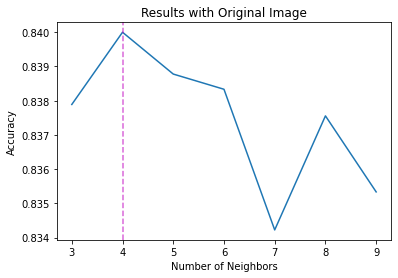

In [ ]:
fig, ax = plt.subplots()
ax.plot(KNN, ori_accuracy)
ax.axvline(KNN[np.argmax(ori_accuracy)], c='m', linestyle='--', alpha=0.6)
ax.set_xlabel('Number of Neighbors')
ax.set_ylabel('Accuracy')
ax.set_xticks(KNN)
ax.set_title('Results with Original Image')
plt.show()

Process with data test with K = 4

In [15]:
time_start = time.time()
 
KNN = 4
ori_label_pred = np.zeros(len(data_test))
for i in range(len(data_test)):
    test_q = data_test[i, :]
    ori_result = knn(data_train, label_train, KNN, test_q)
    ori_label_pred[i] = ori_result
ori_accuracy = np.sum(label_test == ori_label_pred) / len(data_test)
print(ori_accuracy)

time_end=time.time()
print('time cost',time_end-time_start,'s')

0.837
time cost 139.25075101852417 s


#### Process with PCA data

In [ ]:
feature,data_validation_train_pca = pca(data_validation_train,784)
data_validation_test_pca = np.dot(pca_test(data_validation_test,784),feature.T)

In [ ]:
time_start = time.time()
 
KNN = np.arange(3,10)
pca_label_pred = np.zeros(len(data_validation_test_pca))
pca_accuracy = np.zeros(len(KNN))
for k in KNN:
    for i in range(len(data_validation_test_pca)):
        test_q = data_validation_test_pca[i, :]
        pca_result = knn(data_validation_train_pca, label_validation_train, k, test_q)
        pca_label_pred[i] = pca_result
    pca_accuracy[k-3] = np.sum(label_validation_test == pca_label_pred) / len(data_validation_test_pca)
print(pca_accuracy)

time_end=time.time()
print('time cost',time_end-time_start,'s')

[0.84644444 0.84477778 0.845      0.84588889 0.84255556 0.84455556
 0.84188889]
time cost 4323.5812792778015 s


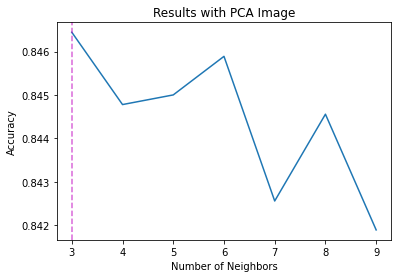

In [ ]:
fig, ax = plt.subplots()
ax.plot(KNN, pca_accuracy)
ax.axvline(KNN[np.argmax(pca_accuracy)], c='m', linestyle='--', alpha=0.6)
ax.set_xlabel('Number of Neighbors')
ax.set_ylabel('Accuracy')
ax.set_xticks(KNN)
ax.set_title('Results with PCA Image')
plt.show()

Process with PCA data test

In [46]:
feature,data_train_pca = pca(data_train,784)
data_test_pca = np.dot(pca_test(data_test,784),feature.T)

In [47]:
time_start = time.time()
 
KNN = 3
pca_label_pred = np.zeros(len(data_test_pca))
for i in range(len(data_test_pca)):
    test_q = data_test_pca[i, :]
    pca_result = knn(data_train_pca, label_train, KNN, test_q)
    pca_label_pred[i] = pca_result
pca_accuracy = np.sum(label_test == pca_label_pred) / len(data_test_pca)
print(pca_accuracy)

time_end=time.time()
print('time cost',time_end-time_start,'s')

0.8335
time cost 141.37724661827087 s


#### Process with SVD data

In [42]:
data_validation_train_svd = svd(data_validation_train, 181)
data_validation_test_svd = svd(data_validation_test, 181)

In [ ]:
time_start = time.time()
 
KNN = np.arange(3,10)
svd_label_pred = np.zeros(len(data_validation_test_svd))
svd_accuracy = np.zeros(len(KNN))
for k in KNN:
    for i in tqdm(range(len(data_validation_test_svd))):
        test_q = data_validation_test_svd[i, :]
        svd_result = knn(data_validation_train_svd, label_validation_train, k, test_q)
        svd_label_pred[i] = svd_result
    svd_accuracy[k-3] = np.sum(label_validation_test == svd_label_pred) / len(data_validation_test_svd)
print(svd_accuracy)

time_end=time.time()
print('time cost',time_end-time_start,'s')

100%|██████████| 9000/9000 [11:06<00:00, 13.50it/s]

[0.85088889 0.85466667 0.85411111 0.85588889 0.85233333 0.85322222
 0.85333333]
time cost 4623.3126356601715 s


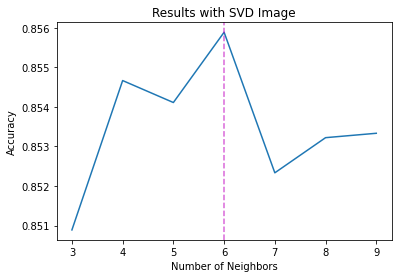

In [ ]:
fig, ax = plt.subplots()
ax.plot(KNN, svd_accuracy)
ax.axvline(KNN[np.argmax(svd_accuracy)], c='m', linestyle='--', alpha=0.6)
ax.set_xlabel('Number of Neighbors')
ax.set_ylabel('Accuracy')
ax.set_xticks(KNN)
ax.set_title('Results with SVD Image')
plt.show()

Process with SVD data test

In [43]:
data_train_svd = svd(data_train, 181)
data_test_svd = svd(data_test, 181)

In [44]:
time_start = time.time()
 
KNN = 6
svd_label_pred = np.zeros(len(data_test_svd))
for i in range(len(data_test_svd)):
    test_q = data_test_svd[i, :]
    svd_result = knn(data_train_svd, label_train, KNN, test_q)
    svd_label_pred[i] = svd_result
svd_accuracy = np.sum(label_test == svd_label_pred) / len(data_test_svd)
print(svd_accuracy)

time_end=time.time()
print('time cost',time_end-time_start,'s')

0.841
time cost 149.11343431472778 s


#### Process with normalization data

In [ ]:
data_validation_train_normalize = normalize(data_validation_train)
data_validation_test_normalize = normalize(data_validation_test)

In [ ]:
time_start = time.time()
 
KNN = np.arange(3,10)
nor_label_pred = np.zeros(len(data_validation_test_normalize))
nor_accuracy = np.zeros(len(KNN))
for k in KNN:
    for i in tqdm(range(len(data_validation_test_normalize))):
        test_q = data_validation_test_normalize[i, :]
        nor_result = knn(data_validation_train_normalize, label_validation_train, k, test_q)
        nor_label_pred[i] = nor_result
    nor_accuracy[k-3] = np.sum(label_validation_test == nor_label_pred) / len(data_validation_test_normalize)
print(nor_accuracy)

time_end=time.time()
print('time cost',time_end-time_start,'s')

100%|██████████| 9000/9000 [07:23<00:00, 20.29it/s]

[0.84188889 0.84288889 0.83922222 0.84311111 0.84233333 0.84144444
 0.83977778]
time cost 3095.0357427597046 s


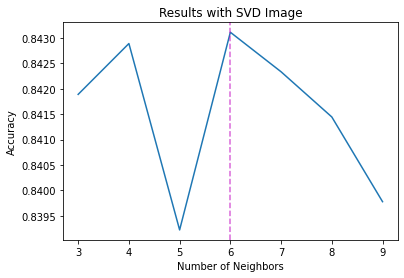

In [ ]:
fig, ax = plt.subplots()
ax.plot(KNN, nor_accuracy)
ax.axvline(KNN[np.argmax(nor_accuracy)], c='m', linestyle='--', alpha=0.6)
ax.set_xlabel('Number of Neighbors')
ax.set_ylabel('Accuracy')
ax.set_xticks(KNN)
ax.set_title('Results with SVD Image')
plt.show()

Process with normalization data test

In [ ]:
data_train_normalize = normalize(data_train)
data_test_normalize = normalize(data_test)

In [ ]:
time_start = time.time()
 
KNN = 6
nor_label_pred = np.zeros(len(data_test_normalize))
for i in range(len(data_test_normalize)):
    test_q = data_test_normalize[i, :]
    nor_result = knn(data_train_normalize, label_train, KNN, test_q)
    nor_label_pred[i] = nor_result
nor_accuracy = np.sum(label_test == nor_label_pred) / len(data_test_normalize)
print(nor_accuracy)

time_end=time.time()
print('time cost',time_end-time_start,'s')

0.833
time cost 137.17207956314087 s


### Naive Bayes

#### Process with original data

In [19]:
nb = NaiveBayes()

time_start = time.time()
min = nb.find_min(data_validation_train)
ori_result = nb.predict(data_validation_train , label_validation_train,data_validation_test )
ori_accuracy = np.sum(label_validation_test == ori_result) / len(data_validation_test)
print(ori_accuracy)

time_end=time.time()
print('time cost',time_end-time_start,'s')

0.6683333333333333
time cost 0.4734783172607422 s


Process with data test

In [20]:
nb = NaiveBayes()

time_start = time.time()
min = nb.find_min(data_train)
ori_result = nb.predict(data_train , label_train,data_test )
ori_accuracy = np.sum(label_test == ori_result) / len(data_test)
print(ori_accuracy)

time_end=time.time()
print('time cost',time_end-time_start,'s')

0.6635
time cost 0.33376002311706543 s


#### Process with PCA data

In [26]:
feature,data_validation_train_pca = pca(data_validation_train,784)
data_validation_test_pca = np.dot(pca_test(data_validation_test,784),feature.T)

In [27]:
nb = NaiveBayes()

time_start = time.time()
min = nb.find_min(data_validation_train_pca)
ori_result = nb.predict(data_validation_train_pca , label_validation_train,data_validation_test_pca )
ori_accuracy = np.sum(label_validation_test == ori_result) / len(data_validation_test_pca)
print(ori_accuracy)

time_end=time.time()
print('time cost',time_end-time_start,'s')

0.6265555555555555
time cost 0.466672420501709 s


Process with PCA data test

In [28]:
feature,data_train_pca = pca(data_train,784)
data_test_pca = np.dot(pca_test(data_test,784),feature.T)

In [29]:
nb = NaiveBayes()
time_start = time.time()
min = nb.find_min(data_train_pca)
pca_result = nb.predict(data_train_pca, label_train, data_test_pca)
pca_accuracy = np.sum(label_test == pca_result) / len(data_test_pca)
print(pca_accuracy)

time_end=time.time()
print('time cost',time_end-time_start,'s')

0.5375
time cost 0.34344911575317383 s


#### Process with SVD data

In [30]:
data_validation_train_svd = svd(data_validation_train, 196)
data_validation_test_svd = svd(data_validation_test, 196)

In [31]:
nb = NaiveBayes()
time_start = time.time()
min = nb.find_min(data_validation_train_svd)
svd_result = nb.predict(data_validation_train_svd, label_validation_train, data_validation_test_svd)
svd_accuracy = np.sum(label_validation_test == svd_result) / len(data_validation_test_svd)
print(svd_accuracy)

time_end=time.time()
print('time cost',time_end-time_start,'s')

0.6044444444444445
time cost 0.47121143341064453 s


Process with SVD data test

In [32]:
data_train_svd = svd(data_train, 196)
data_test_svd = svd(data_test, 196)

In [33]:
nb = NaiveBayes()
time_start = time.time()
min = nb.find_min(data_train_svd)
svd_result = nb.predict(data_train_svd, label_train, data_test_svd)
svd_accuracy = np.sum(label_test == svd_result) / len(data_test_svd)
print(svd_accuracy)

time_end=time.time()
print('time cost',time_end-time_start,'s')

0.6305
time cost 0.3285486698150635 s


#### Process with nornalization data

In [37]:
data_validation_train_normalize = normalize(data_validation_train)
data_validation_test_normalize = normalize(data_validation_test)

In [41]:
nb = NaiveBayes()
time_start = time.time()
min = nb.find_min(data_validation_train_normalize)
nor_result = nb.predict(data_validation_train_normalize, label_validation_train, data_validation_test_normalize)
nor_accuracy = np.sum(label_validation_test == nor_result) / len(data_validation_test_normalize)
print(nor_accuracy)

time_end=time.time()
print('time cost',time_end-time_start,'s')

0.6683333333333333
time cost 0.45896005630493164 s


Process with normalization data test

In [39]:
data_train_normalize = normalize(data_train)
data_test_normalize = normalize(data_test)

In [40]:
nb = NaiveBayes()
time_start = time.time()
min = nb.find_min(data_train_normalize)
nor_result = nb.predict(data_train_normalize, label_train, data_test_normalize)
nor_accuracy = np.sum(label_test == nor_result) / len(data_test_normalize)
print(nor_accuracy)

time_end=time.time()
print('time cost',time_end-time_start,'s')

0.6635
time cost 0.33322763442993164 s
